### Первоначальная настройка

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from datetime import datetime, timedelta
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import hdbscan
from scipy.stats import mannwhitneyu

import mlflow

Отключение предупеждений

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

Путь к директориям

In [3]:
dir = os.path.abspath('..')
data_dir = f'{dir}/data'
mlflow_dir = f'{dir}/mlruns'

Настройки отображения

In [4]:
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')

Настройка MLflow

In [5]:
mlflow.set_tracking_uri(f'file:///{mlflow_dir}')
mlflow.set_experiment('fraud_analysis_xgbost')

<Experiment: artifact_location='file:////Users/elizaveta/Downloads/fraud_backend/mlruns/653502166279933628', creation_time=1746613653888, experiment_id='653502166279933628', last_update_time=1746613653888, lifecycle_stage='active', name='fraud_analysis_xgbost', tags={}>

Запуск окружения mlFlow происходит внутри терминала при помощи команды 

`mlflow ui --backend-store-uri file://$(pwd)/mlflow_local`

### Загрузка данных

In [6]:
train_id = pd.read_parquet(f'{data_dir}/train_identity.parquet.gzip')
train_tr = pd.read_parquet(f'{data_dir}/train_transaction.parquet.gzip')

test_id = pd.read_parquet(f'{data_dir}/test_identity.parquet.gzip')
test_tr = pd.read_parquet(f'{data_dir}/test_transaction.parquet.gzip')

In [7]:
train = train_tr.merge(train_id, how='left', on='TransactionID')
test = test_tr.merge(test_id, how='left', on='TransactionID')

### Разведочный анализ данных - EDA

Размер датасета

In [8]:
train_rows = train.shape[0]
train_columns = train.shape[1]

test_rows = test.shape[0]
test_columns = test.shape[1]

print(f'Обучающая выборка: \n количество строк - {train_rows} \n количество столбцов - {train_columns}')
print(f'Тестовая выборка: \n количество строк - {test_rows} \n количество столбцов - {test_columns}')

Обучающая выборка: 
 количество строк - 1342281 
 количество столбцов - 434
Тестовая выборка: 
 количество строк - 1321087 
 количество столбцов - 434


In [9]:
train['isFraud'].value_counts(normalize=True)

isFraud
0    0.960556
1    0.039444
Name: proportion, dtype: float64

Тестовая выборка чуть меньше по количеству строк, но в целом их число примерно равно. 
В тестовой выборке отсутствует столбец isFraud, остальные столбцы одни и те же.

In [10]:
missing_stats_train = pd.DataFrame({
    'Столбец': train.columns,
    'Пропусков': train.isna().sum(),
}).assign(
    **{'Процент пропусков': lambda x: (x['Пропусков']/ train_rows * 100).round(1)}
)

missing_stats_train = missing_stats_train.sort_values(by='Процент пропусков', ascending=False)
display(missing_stats_train)

,Столбец,Пропусков,Процент пропусков
id_24,id_24,1299511,96.8
id_25,id_25,1296043,96.6
id_22,id_22,1295710,96.5
id_26,id_26,1295764,96.5
id_08,id_08,1295837,96.5
...,...,...,...
V311,V311,22,0.0
V310,V310,22,0.0
V309,V309,22,0.0
V308,V308,22,0.0


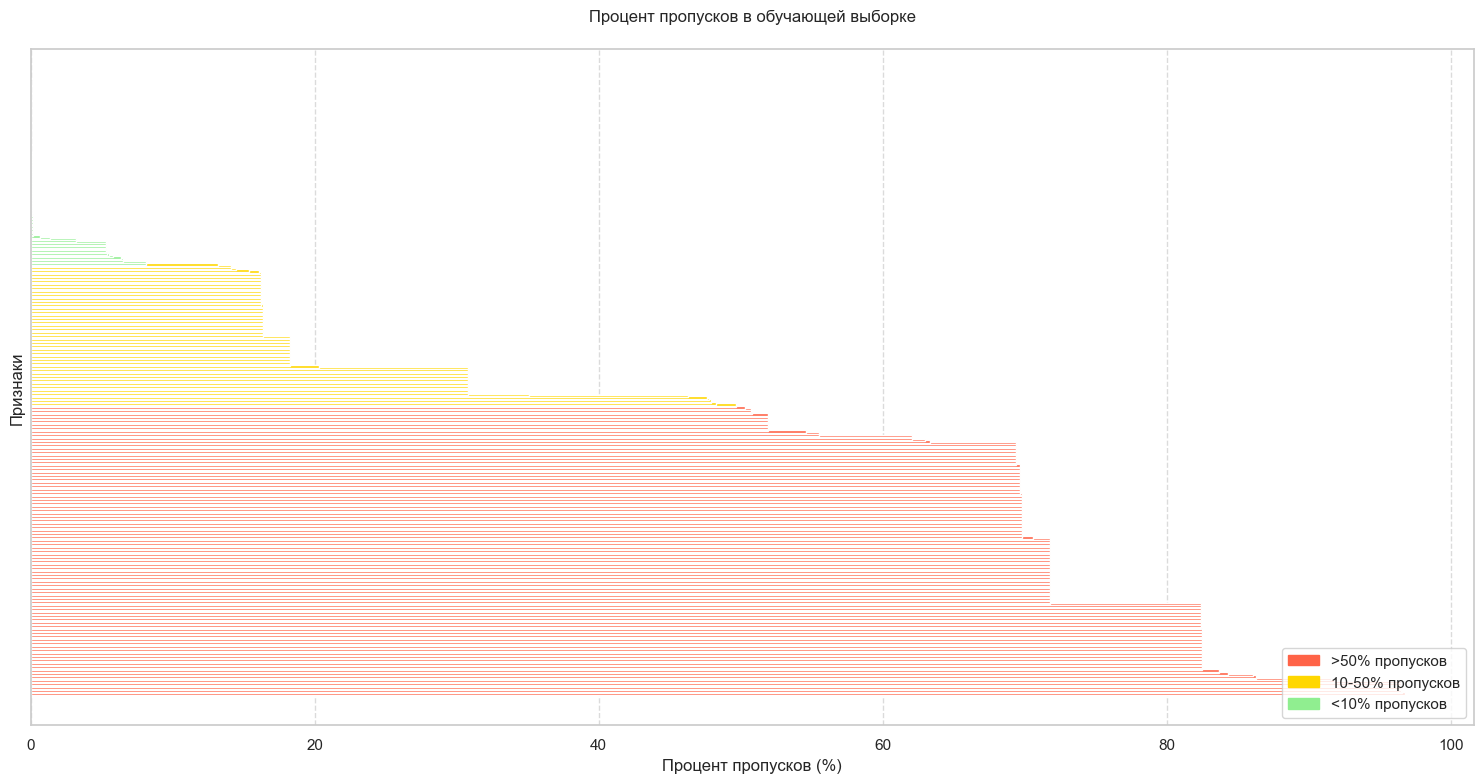

In [11]:
plt.figure(figsize=(15, 8))


missing_sorted = missing_stats_train.sort_values('Процент пропусков', ascending=False)

colors = np.where(missing_sorted['Процент пропусков'] > 50, 'tomato',
                 np.where(missing_sorted['Процент пропусков'] > 10, 'gold',
                         'lightgreen'))

bars = plt.barh(
    y=range(len(missing_sorted)),
    width=missing_sorted['Процент пропусков'],
    color=colors,
    height=1.8 
)


plt.yticks([])
plt.title('Процент пропусков в обучающей выборке', pad=20)
plt.xlabel('Процент пропусков (%)')
plt.ylabel('Признаки')
plt.grid(axis='x', linestyle='--', alpha=0.7)

legend_handles = [
    mpatches.Patch(color='tomato', label='>50% пропусков'),
    mpatches.Patch(color='gold', label='10-50% пропусков'),
    mpatches.Patch(color='lightgreen', label='<10% пропусков')
]
plt.legend(handles=legend_handles, loc='lower right')

plt.tight_layout()
plt.show()


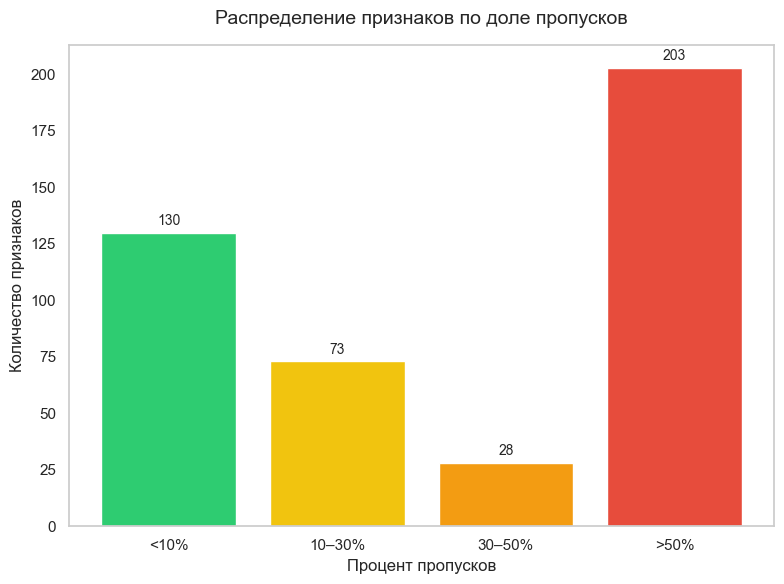

In [12]:
plt.figure(figsize=(8, 6))

bins = [0, 10, 30, 50, 100]
labels = ['<10%', '10–30%', '30–50%', '>50%']
missing_sorted['Категория'] = pd.cut(missing_sorted['Процент пропусков'], bins=bins, labels=labels, include_lowest=True)

category_counts = missing_sorted['Категория'].value_counts().sort_index()


bars = plt.bar(category_counts.index, category_counts.values, color=['#2ecc71', '#f1c40f', '#f39c12', '#e74c3c'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Распределение признаков по доле пропусков', fontsize=14, pad=15)
plt.ylabel('Количество признаков')
plt.xlabel('Процент пропусков')
plt.tight_layout()
plt.grid(False)
plt.show()


График позволяет визуально выбрать разумный порог отсечения признаков по доле пропусков — например, оставить только признаки с <30% или <10% пропусков.

Ступеньки на графике означают, что несколько признаков имеют одинаковый процент пропусков, что указывает на групповые зависимости, например, если признаки появляются только для определённых типов транзакций. Однако эта гипотеза не проверялась, так как было принято решение исключить все признаки с отсутствующими значениями для упрощения пайплайна обработки и сосредоточения на интерпретируемых и качественно заполненных данных.

Больше половины признаков содержат более 50% пропущенных значений, тогда как лишь незначительная часть столбцов имеет долю пропусков менее 10%. Это свидетельствует о высоком уровне пропусков в данных и ограниченной возможности для их восстановления без искажения распределений. В целях обеспечения корректного обучения моделей было принято решение исключить из дальнейшего анализа все признаки, оставить все данные без пропусков, исключить все признаки группы V (V1–V339), поскольку они были сгенерированы владельцем данных на основе уже имюещихся, а также проанализировать данные с временными дельтами.

In [13]:
no_nans = [col for col in train.columns if train[col].isna().sum() == 0]

print('Признаки без пропусков:')
for i, col in enumerate(no_nans):
    print(f'{i+1}. {col}')

Признаки без пропусков:
1. TransactionID
2. isFraud
3. TransactionDT
4. TransactionAmt
5. ProductCD
6. card1
7. C1
8. C2
9. C3
10. C4
11. C5
12. C6
13. C7
14. C8
15. C9
16. C10
17. C11
18. C12
19. C13
20. C14


#### Выделение значимых признаков из колонок временных дельт

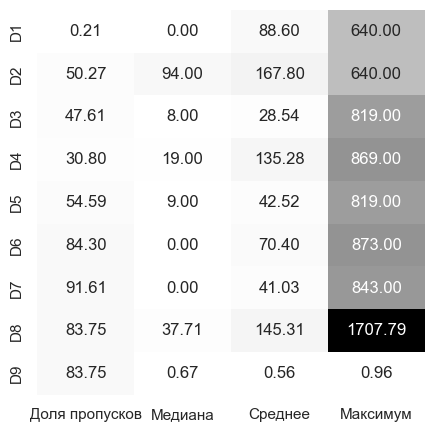

In [14]:
d_cols_to_check = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']

d_stats = {
    'Признак': [],
    'Доля пропусков': [],
    'Медиана': [],
    'Среднее': [],
    'Максимум': []
}

for col in d_cols_to_check:
    missing_percent = train[col].isna().mean() * 100
    median = train[col].median()
    mean = train[col].mean()
    maximum = train[col].max()
    
    d_stats['Признак'].append(col)
    d_stats['Доля пропусков'].append(round(missing_percent, 2))
    d_stats['Медиана'].append(round(median, 2))
    d_stats['Среднее'].append(round(mean, 2))
    d_stats['Максимум'].append(round(maximum, 2))

df_dstats = pd.DataFrame(d_stats)

plt.figure(figsize=(5, 5))
ax = sns.heatmap(df_dstats.set_index('Признак')[['Доля пропусков', 'Медиана', 'Среднее', 'Максимум']],
            annot=True, fmt='.2f', cmap='Greys', cbar=False)
#plt.title('Анализ признаков D1–D9')
ax.set_ylabel('') 
plt.show()


df_dstats = pd.DataFrame(d_stats)

Из графика видно, что признак D1 практически не содержит пропусков и характеризуется высокой количеством нулевых значений, что может соответствовать мгновенно совершаемым транзакциям. Признаки D6–D9 имеют более 80% пропусков, что затрудняет их использование в модели без предварительной обработки.

Особенно выделяется признак D8, имеющий высокие среднее и максимальное значения, существенно превышающие аналогичные показатели других признаков, что может свидетельствовать о наличии выбросов или иной природы измерения. Признак D9 по шкале и распределению существенно отличается от остальных, вероятно, представляя нормализованную долю.

In [15]:
d_cols_use = ['D1', 'D6', 'D7', 'D8']

results = {}
for col in d_cols_use:
    fraud = train.loc[train['isFraud'] == 1, col].dropna()
    non_fraud = train.loc[train['isFraud'] == 0, col].dropna()
    
    stat, p = mannwhitneyu(fraud, non_fraud, alternative='two-sided')
    auc = stat / (len(fraud) * len(non_fraud))
    
    results[col] = {
        'U-статистика': stat,
        'p-value': p,
        'AUC (эффект)': auc,
        'Медиана (fraud)': fraud.median(),
        'Медиана (non-fraud)': non_fraud.median()
    }

df = pd.DataFrame(results).T
df_formatted = df.copy()
df_formatted['U-статистика'] = df['U-статистика'].round(1)
df_formatted['p-value'] = df['p-value'].round(4)
df_formatted['AUC (эффект)'] = df['AUC (эффект)'].round(4)
df_formatted['Медиана (fraud)'] = df['Медиана (fraud)'].round(2)
df_formatted['Медиана (non-fraud)'] = df['Медиана (non-fraud)'].round(2)

display(df_formatted.style.set_caption('Результаты U-теста Манна–Уитни по D-признакам')
        .format({
            'U-статистика': '{:.1f}',
            'p-value': '{:.1f}',
            'AUC (эффект)': '{:.4f}',
            'Медиана (fraud)': '{:.2f}',
            'Медиана (non-fraud)': '{:.2f}'
        }))
        




,U-статистика,p-value,AUC (эффект),Медиана (fraud),Медиана (non-fraud)
D1,27557838994.0,0.0,0.4055,0.00,1.00
D6,2171970383.0,0.0,0.5130,0.00,0.00
D7,568133456.5,0.0,0.3515,0.00,0.00
D8,1409102281.5,0.0,0.3127,2.25,50.54


Признак D1 включён как почти полностью заполненный и потенциально важный, D6, D7 и D8 продемонстрировали важные свойства распределения, в связи с чем, признаки были оставлены для проверки статистической значимости. Остальные признаки D-группы либо имели схожую структуру с уже анализируемыми, либо не соответствовали масштабу временных дельт и потому не были протестированы отдельно.

Для проверки корреляции отобранных временных дельт с целевой переменной isFraud был использован Критерий Манна-Уитни, так как отобранные данные не нормализованы, присутствуют выбросы, распределения не нормальны, а также целевая переменная бинарна.

Интрепретация результатов U-теста:
- если p-value < 0.05, то распределения значимо различаются, следовательно, признак полезен для обнаружения фрода.
- если AUC > 0.5, то для переменной мошеннических значений больше, чем немошеннических, если AUC < 0.5, тогда наоборот: для переменной немошеннических значений больше, чем мошеннических, если AUC = 0.5, тогда нет различий.

**D1**
- p_valye ≈ 0, ледовательно, значение значимое
- AUC ≈ 0.4, следовательно, легитимых транзакций больше, чем фрода
- медиана для фрода 0 секунд, медиана для не фрода 4 секунды, следовательно, фродовые транзакции происходят быстрее, чем легальные
Вывод: D1 значимый признак 

**D6**
- p_valye ≈ 0.5, cледовательно, значение значимое
- AUC ≈ 0.5, следовательно, различий практически нет
- разницы в медианах между фродовыми и легитимными транзакциями нет
Вывод: D6 можно исключить, так как у него слабая предсказательная сила AUC


**D7**
- p_valye ≈ 0 cледовательно, значение значимое
- AUC ≈ 0.35, следовательно, легитимых транзакций больше, чем фрода
- разницы в медианах между фродовыми и легитимными транзакциями нет
Вывод: D7 значимый признак


**D8**
- p_valye ≈ 0 cледовательно, значение значимое
- AUC ≈ 0.3, следовательно, легитимых транзакций больше, чем фрода
- медиана для фрода 2,3 секунд, медиана для не фрода 50,6 секунды, следовательно, фродовые транзакции происходят быстрее, чем легальные
Вывод: D8 значимый признак


#### Преобразование дат и выделение новых признаков

In [16]:
START_DATE = datetime(2017, 11, 30)  
train['TransactionDT'] = train['TransactionDT'].astype(int)
train['TransactionDate'] = train['TransactionDT'].apply(lambda x: START_DATE + timedelta(seconds=x))
train['Transaction_day'] = train['TransactionDate'].dt.day
train['Transaction_month'] = train['TransactionDate'].dt.month
train['Transaction_weekday'] = train['TransactionDate'].dt.weekday
train['Transaction_hour'] = train['TransactionDate'].dt.hour

In [17]:
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return '0'
    elif 6 <= hour < 12:
        return '1'
    elif 12 <= hour < 18:
        return '2'
    else:
        return '3'

train['Transaction_part_of_day'] = train['Transaction_hour'].apply(get_time_of_day)

In [18]:
all_columns = train.columns

categorical_features = [
    'DeviceType', 'DeviceInfo', 
    'ProductCD', 
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
    'addr1', 'addr2', 
    'P_emaildomain', 'R_emaildomain'
]

numerical_features = [
    'TransactionAmt', 
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
    'D1'
]

binary_features = [
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

date_features = [
    'TransactionDT', 'TransactionDate', 'Transaction_day', 'Transaction_month', 'Transaction_weekday', 'Transaction_hour', 'Transaction_part_of_day'
]

id_features = ['TransactionID']


print(f'Числовые признаки: {numerical_features}')
print(f'Категориальные признаки: {categorical_features}')
print(f'Бинарные признаки: {binary_features}')
print(f'Временные признаки: {date_features}')

Числовые признаки: ['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']
Категориальные признаки: ['DeviceType', 'DeviceInfo', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']
Бинарные признаки: ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
Временные признаки: ['TransactionDT', 'TransactionDate', 'Transaction_day', 'Transaction_month', 'Transaction_weekday', 'Transaction_hour', 'Transaction_part_of_day']


### Создание цепочек с помощью HDBSCAN

Кластеризация через HDBSCAN

- автоматическое определение количества кластеров,
- работа с кластерами произвольной формы,
- поиск выбросов

In [19]:
train['user_id'] = train[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']].astype(str).agg('_'.join, axis=1)
train = train.sort_values(by=['user_id', 'TransactionDT'])

In [ ]:
train = train.copy()
train['chain_id'] = np.nan

chain_id_counter = 0

for user_id, group in train.groupby('user_id'):

    if len(group) == 1:
        train.loc[group.index, 'chain_id'] = chain_id_counter
        chain_id_counter += 1
        continue

    X_time = group[['TransactionDT']].astype(float)
    X_scaled = StandardScaler().fit_transform(X_time)

    try:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
        labels = clusterer.fit_predict(X_scaled)

        for label in set(labels):
            if label != -1:
                train.loc[group.index[labels == label], 'chain_id'] = chain_id_counter
                chain_id_counter += 1

        train.loc[group.index[labels == -1], 'chain_id'] = chain_id_counter
        chain_id_counter += 1

    except ValueError as e:
        print(f'Ошибка в user_id={user_id}: {e}')
        continue


In [ ]:
chain_stats = train.dropna(subset=['chain_id'])

chain_stats['chain_id'] = train['chain_id'].astype(int)

chain_sizes = chain_stats.groupby('chain_id').size()

total_chains = chain_sizes.shape[0]
avg_tx_per_chain = chain_sizes.mean()
max_tx_per_chain = chain_sizes.max()
min_tx_per_chain = chain_sizes.min()
percent_of_total = len(chain_stats) / len(train) * 100

fraud_transactions = chain_stats[chain_stats['isFraud'] == 1]
normal_transactions = chain_stats[chain_stats['isFraud'] == 0]

percent_fraud = len(fraud_transactions) / len(chain_stats) * 100
percent_normal = len(normal_transactions) / len(chain_stats) * 100

print(f'Всего цепочек: {total_chains}')
print(f'Среднее количество транзакций в цепочке: {avg_tx_per_chain:.2f}')
print(f'Максимум транзакций в одной цепочке: {max_tx_per_chain}')
print(f'Минимум транзакций в одной цепочке: {min_tx_per_chain}')
print(f'Доля транзакций, попавших в цепочки: {percent_of_total:.2f}%')
print(f'Доля фродовых транзакций среди цепочек: {percent_fraud:.2f}%')
print(f'Доля нормальных транзакций среди цепочек: {percent_normal:.2f}%')


Всего цепочек: 345971
Среднее количество транзакций в цепочке: 3.88
Максимум транзакций в одной цепочке: 1678
Минимум транзакций в одной цепочке: 1
Доля транзакций, попавших в цепочки: 100.00%
Доля фродовых транзакций среди цепочек: 3.94%
Доля нормальных транзакций среди цепочек: 96.06%


In [ ]:
# Определим фродовые цепочки: хотя бы одна транзакция с isFraud = 1
fraud_chains = chain_stats.groupby('chain_id')['isFraud'].max().reset_index()
fraud_chains['is_fraud_chain'] = fraud_chains['isFraud'] == 1

# Подсчитаем
n_fraud_chains = fraud_chains['is_fraud_chain'].sum()
n_total_chains = fraud_chains.shape[0]
n_legit_chains = n_total_chains - n_fraud_chains

# Доли
percent_fraud_chains = n_fraud_chains / n_total_chains * 100
percent_legit_chains = n_legit_chains / n_total_chains * 100

print(f'Фродовых цепочек: {n_fraud_chains} ({percent_fraud_chains:.2f}%)')
print(f'Легитимных цепочек: {n_legit_chains} ({percent_legit_chains:.2f}%)')


Фродовых цепочек: 18381 (5.31%)
Легитимных цепочек: 327590 (94.69%)


Все транзакции были сгруппированы в 345 971 цепочку, при этом среднее число операций в одной цепочке составило 3.88. Минимальная длина цепочки — 1, максимальная — 1678. Доля фродовых транзакций среди всех составила 3.94%, что сопоставимо с общим уровнем фрода в выборке, и подтверждает корректность кластеризации.

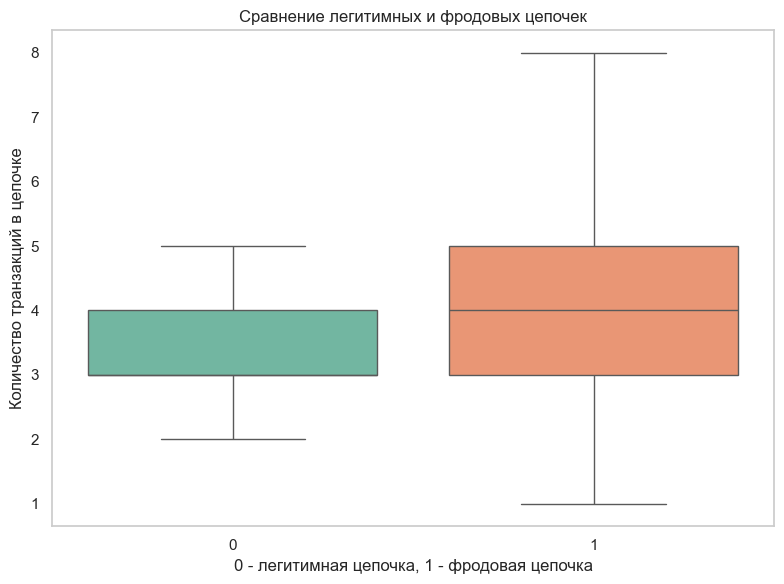

In [ ]:
chain_sizes = chain_stats.groupby('chain_id').size().reset_index(name='chain_length')
chain_fraud = chain_stats.groupby('chain_id')['isFraud'].max().reset_index()
chain_info = chain_sizes.merge(chain_fraud, on='chain_id')

plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='chain_length', data=chain_info, showfliers=False, palette='Set2')
#plt.title('Сравнение легитимных и фродовых цепочек')
plt.xlabel('0 - легитимная цепочка, 1 - мошенническая цепочка')
plt.ylabel('Количество транзакций в цепочке')
plt.grid(False)
plt.tight_layout()
plt.show()


Видно, что фродовые цепочки в среднем немного длиннее и характеризуются более высокой вариативностью. Это может свидетельствовать о том, что мошенники совершают серии транзакций, объединённые по платёжным средствам и временным признакам.
На основании этой информации признак `chain_length` может быть использован в качестве одного из факторов в модели машинного обучения.

### Обучение моделей

Установка названия эксперимента

In [ ]:
mlflow.set_experiment('notebook_fraud_detection')

<Experiment: artifact_location='file:////Users/elizaveta/Downloads/fraud_backend_full/mlruns/216605230211250643', creation_time=1746447653877, experiment_id='216605230211250643', last_update_time=1746447653877, lifecycle_stage='active', name='notebook_fraud_detection', tags={}>

Кодирование цепочек по card1-6

In [ ]:
le_chain = LabelEncoder()
train['chain_id'] = le_chain.fit_transform(train['chain_id'])

Агрегация цепочек

In [ ]:
chain_agg = train.groupby('chain_id').agg({
    'TransactionAmt': ['mean', 'sum', 'std'],
    'TransactionID': 'count',
    'D1': ['mean', 'sum', 'std'],
    'isFraud': ['mean', 'sum']
}).reset_index()

chain_agg.columns = ['chain_id', 
                     'chain_amt_mean', 'chain_amt_sum', 'chain_amt_std',
                     'chain_trans_count',
                     'chain_D1_mean', 'chain_D1_sum', 'chain_D1_std',
                     'chain_fraud_rate', 'chain_fraud_sum']
chain_agg['isFraud_chain'] = (chain_agg['chain_fraud_sum'] > 0).astype(int)

print(chain_agg.head())

   chain_id  chain_amt_mean  chain_amt_sum  chain_amt_std  chain_trans_count  \
0         0       29.000000      58.000000            0.0                  2   
1         1       39.394001     118.182007            0.0                  3   
2         2       19.093000      57.278999            0.0                  3   
3         3       10.755000      21.510000            0.0                  2   
4         4       19.093000     114.557999            0.0                  6   

   chain_D1_mean  chain_D1_sum  chain_D1_std  chain_fraud_rate  \
0           83.0         166.0           0.0               0.0   
1            7.0          21.0           0.0               0.0   
2           10.0          30.0           0.0               0.0   
3            9.0          18.0           0.0               0.0   
4            9.0          54.0           0.0               0.0   

   chain_fraud_sum  isFraud_chain  
0                0              0  
1                0              0  
2             

Соединение статистических данных с общей тестовой выборкой

In [ ]:
train_transaction = train.merge(chain_agg, on='chain_id', how='left')

mapping = {'T': 1, 'F': 0, None: -999, np.nan: -999} 

for col in train_transaction.columns:
    if col in categorical_features:
        print(col)
        le = LabelEncoder()
        train_transaction[col] = train_transaction[col].fillna('missing').astype(str)
        train_transaction[col] = le.fit_transform(train_transaction[col])
        #joblib.dump(le, f'encoders/{col}.pkl')
    if col in binary_features:
        train_transaction[col] = train_transaction[col].map(mapping)


ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
P_emaildomain
R_emaildomain
DeviceType
DeviceInfo


Обучение модели по отдельным транзакциям

In [ ]:
features_transaction = [col for col in (numerical_features + categorical_features + binary_features)]
X_transaction = train_transaction[features_transaction]
y_transaction = train_transaction['isFraud']

X_train_transaction, X_test_transaction, y_train_transaction, y_test_transaction = train_test_split(X_transaction, y_transaction, test_size=0.25, random_state=42, stratify=y_transaction)

print(X_train_transaction.dtypes)


with mlflow.start_run(run_name='model_transaction'):
    params_transaction = {
        'max_depth': 10,
        'learning_rate': 0.1,
        'n_estimators': 4000,
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'missing': -1,
        'random_state': 42,
        'eval_metric': 'auc'
    }

    mlflow.log_params(params_transaction)

    model_transaction = xgb.XGBClassifier(**params_transaction)
    model_transaction.fit(X_train_transaction, y_train_transaction)

    mlflow.xgboost.log_model(model_transaction, 'model_transaction')

    y_pred = model_transaction.predict(X_test_transaction)
    y_proba = model_transaction.predict_proba(X_test_transaction)[:, 1]

    metrics_transaction = {
        'auc': roc_auc_score(y_test_transaction, y_proba),
        'accuracy': accuracy_score(y_test_transaction, y_pred),
        'fraud_precision': precision_score(y_test_transaction, y_pred, pos_label=1),
        'fraud_recall': recall_score(y_test_transaction, y_pred, pos_label=1),
        'fraud_f1': f1_score(y_test_transaction, y_pred, pos_label=1),
    }

    mlflow.log_metrics(metrics_transaction)

    importances = model_transaction.feature_importances_
    feature_importances_df = pd.DataFrame({
        'Feature': X_train_transaction.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(50))
    plt.title('Топ-50 важных признаков (model_transaction)')
    plot_path_transaction = 'feature_importance_transaction.png'
    plt.savefig(plot_path_transaction)
    plt.close()

    mlflow.log_artifact(plot_path_transaction)
    feature_importances_df.head(20).to_csv('top_features_transaction.csv', index=False)
    mlflow.log_artifact('top_features_transaction.csv')

    print('Model transaction — AUC:', metrics_transaction['auc'])
    #print(classification_report(y_test_transaction, y_pred))


TransactionAmt    float32
C1                float32
C2                float32
C3                float32
C4                float32
C5                float32
C6                float32
C7                float32
C8                float32
C9                float32
C10               float32
C11               float32
C12               float32
C13               float32
C14               float32
D1                float32
DeviceType          int64
DeviceInfo          int64
ProductCD           int64
card1               int64
card2               int64
card3               int64
card4               int64
card5               int64
card6               int64
addr1               int64
addr2               int64
P_emaildomain       int64
R_emaildomain       int64
M1                  int64
M2                  int64
M3                  int64
M4                float64
M5                  int64
M6                  int64
M7                  int64
M8                  int64
M9                  int64
dtype: objec

/Users/elizaveta/Downloads/fraud_backend_full/venv/lib/python3.13/site-packages/xgboost/sklearn.py:1028: UserWarning: [14:27:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/05 14:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model transaction — AUC: 0.9934701452437689


Обучение модели по цепочкам транзакций

In [ ]:
X_chain = chain_agg[['chain_id', 
                     'chain_amt_mean', 'chain_amt_sum', 'chain_amt_std',
                     'chain_trans_count',
                     'chain_D1_mean', 'chain_D1_sum', 'chain_D1_std']]

y_chain = chain_agg['isFraud_chain']

with mlflow.start_run(run_name='model_chain'):
    params_chain = {
        'max_depth': 10,
        'learning_rate': 0.1,
        'n_estimators': 4000,
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'missing': -1,
        'random_state': 42,
        'eval_metric': 'auc'
    }

    metrics_transaction = {
        'auc': roc_auc_score(y_test_transaction, y_proba),
        'accuracy': accuracy_score(y_test_transaction, y_pred),
        'fraud_precision': precision_score(y_test_transaction, y_pred, pos_label=1),
        'fraud_recall': recall_score(y_test_transaction, y_pred, pos_label=1),
        'fraud_f1': f1_score(y_test_transaction, y_pred, pos_label=1),
    }

    mlflow.log_params(params_chain)
    mlflow.log_metrics(metrics_transaction)

    model_chain = xgb.XGBClassifier(**params_chain)
    model_chain.fit(X_chain, y_chain)

    mlflow.xgboost.log_model(model_chain, 'model_chain')

    y_chain_proba = model_chain.predict_proba(X_chain)[:, 1]
    auc_chain = roc_auc_score(y_chain, y_chain_proba)
    mlflow.log_metric('auc_chain', auc_chain)

    print('Model chain - AUC:', auc_chain)


/Users/elizaveta/Downloads/fraud_backend_full/venv/lib/python3.13/site-packages/xgboost/sklearn.py:1028: UserWarning: [14:28:39] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/05 14:28:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model chain - AUC: 0.9959659312191594


Возвращение вероятности цепочки в train_transaction

In [ ]:
chain_agg['chain_proba'] = y_chain_proba
train_transaction = train_transaction.merge(chain_agg[['chain_id', 'chain_proba']], on='chain_id', how='left')


Обучение финальной модели

In [ ]:
features_final = features_transaction + ['chain_proba']
X_final = train_transaction[features_final]
y_final = train_transaction['isFraud']


X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.25, stratify=y_final, random_state=42)

with mlflow.start_run(run_name='model_final'):
    params_final = {
        'max_depth': 10,
        'learning_rate': 0.1,
        'n_estimators': 4000,
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'missing': -1,
        'random_state': 42,
        'eval_metric': 'auc',
        'smote_sampling_strategy': 'auto',
        'k_neighbors': 5,
        'n_jobs': 1
    }

    mlflow.log_params(params_final)

    model_final = xgb.XGBClassifier(**params_final)
    model_final.fit(X_train_final, y_train_final)


    mlflow.xgboost.log_model(model_final, 'model_final')

    y_pred_final = model_final.predict(X_test_final)
    y_proba_final = model_final.predict_proba(X_test_final)[:, 1]

    metrics_final = {
        'auc': roc_auc_score(y_test_final, y_proba_final),
        'accuracy': accuracy_score(y_test_final, y_pred_final),
        'fraud_precision': precision_score(y_test_final, y_pred_final, pos_label=1),
        'fraud_recall': recall_score(y_test_final, y_pred_final, pos_label=1),
        'fraud_f1': f1_score(y_test_final, y_pred_final, pos_label=1),
    }

    mlflow.log_metrics(metrics_final)

    importances_final = model_final.feature_importances_
    fi_final = pd.DataFrame({
        'Feature': X_train_final.columns,
        'Importance': importances_final
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_final.head(50))
    plt.title('Топ-50 признаков (model_final)')
    plot_path_final = 'feature_importance_final.png'
    plt.savefig(plot_path_final)
    plt.close()

    mlflow.log_artifact(plot_path_final)
    fi_final.head(20).to_csv('top_features_final.csv', index=False)
    mlflow.log_artifact('top_features_final.csv')

    print('Model final — AUC:', metrics_final['auc'])


/Users/elizaveta/Downloads/fraud_backend_full/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "k_neighbors", "smote_sampling_strategy" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/elizaveta/Downloads/fraud_backend_full/venv/lib/python3.13/site-packages/xgboost/sklearn.py:1028: UserWarning: [14:36:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/05 14:36:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model final — AUC: 0.999385792472869


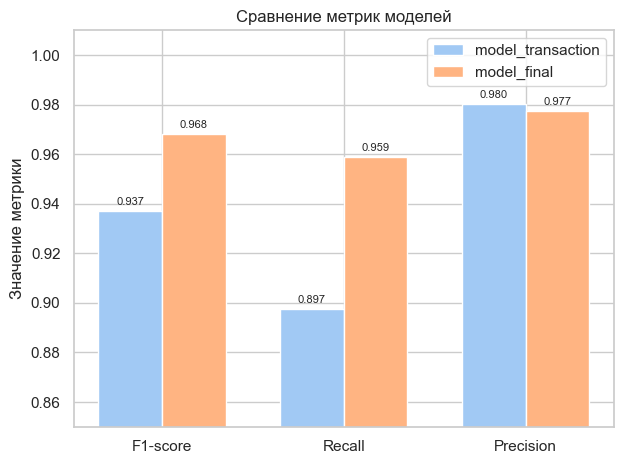

In [ ]:
metrics = ['fraud_f1', 'fraud_recall', 'fraud_precision']

model_transaction = [metrics_transaction[m] for m in metrics]
model_final = [metrics_final[m] for m in metrics]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar([i - width/2 for i in x], model_transaction, width=width, label='model_transaction', color='#A1C9F4')
bars2 = ax.bar([i + width/2 for i in x], model_final, width=width, label='model_final', color='#FFB482')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

ax.set_xticks(list(x))
ax.set_xticklabels(['F1-score', 'Recall', 'Precision']) 
ax.set_ylim(0.85, 1.01)
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик моделей')
ax.legend()
plt.tight_layout()
plt.show()
